In [1]:
import datetime
import time
from transformers import AutoModel, AutoTokenizer, AutoConfig
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import transformers
from data_processor import process_sarc_data_for_training

In [2]:
# specify GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# load data into dataframe
df = pd.concat(process_sarc_data_for_training(), axis=0)
# let's look at a sample
print(df.sample(10))

        class                                               text
id                                                              
2396  notsarc  So my question is this: Why doesn't a chihuahu...
4780     sarc  So? God also says he made you out of dirt and ...
1645     sarc  You mean back in 1993 when Clinton had been in...
2789     sarc  I like the idea of sterilization for rightwing...
103   notsarc  Actually Montalban, there is a federal ordinan...
2171  notsarc  Why do people on the pro-gun side continuously...
281   notsarc  Yes. The assumption happens to be that maybe t...
828   notsarc  I googled your signature, and I found this jus...
6411     sarc  Funny how people who are "for" capital punishm...
1377  notsarc  Indeed.  If a teacher teaches 'the controverse...


In [4]:
# our labels need to be numeric, so let's replace that now
# [0] for notsarc and [1] for sarc
df['class'] = df['class'].replace(['notsarc', 'sarc'], [0, 1])

In [5]:
# split train dataset into train, validation and test sets
# using the sklearn package for splitting
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['class'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['class'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [6]:
# load the model
bert = AutoModel.from_pretrained('bert-base-uncased')

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# now we process the data for training

this includes:
- tokenizing the data
- adding special tokens
- padding/truncating text to be of fixed length

let's first take a look at the length distribution of our data

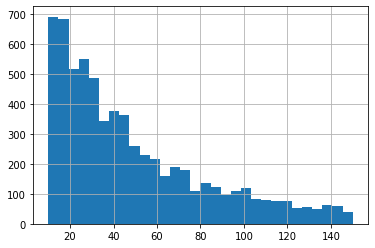

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

# plot the distribution
series = pd.Series(seq_len).hist(bins=30)
plt.show()  # we can see that most of our data is around length 20, but it extends up to 140

we'll pad/truncate our sentences to 100
it will make training slower, but that's ok for our purposes

In [8]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=100,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\b\anaconda3\envs\alice\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


our data is now encoded and the lengths normalized

In [9]:
# let's convert the lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())



now lets put our data into a dataloader, for simplicity when loading our data when training

In [10]:
# define a batch size (recommended 16 or 32)
# cut in half for my cuda
batch_size = 8

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [11]:
# test data
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# wrap tensors
test_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# now let's define our model architecture

In [12]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):
        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [13]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

lets set our optimizer and learning rate

In [14]:
# we will use AdamW as our optimizer
optimizer = AdamW(model.parameters(),
                  lr=1e-5)  # learning rate

In [15]:
# compute the class weights -- initially at 1
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:", class_weights)

Class Weights: [1. 1.]


### now we'll define our loss with the weights

In [16]:
# converting list of class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 2

now that we've done our data preprocessing, data loading, defined our models with the optimizer, loss functions
and weights,
# we can start training.
this entails:
- creating a train function to train the model
- creating an evaluator function to evaluate our results

first we'll create a train function

In [17]:
def train():
    # put our model into a training state
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

        # free predictions from gpu
        del preds

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds

this is a helper function for formatting our time elapsed

In [18]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

now we'll create an evaluation function for evaluating validation loss

In [19]:
def evaluate(dataloader=val_dataloader):
    print("\nEvaluating...")
    t0 = time.time()

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

            # free predictions from gpu
            del preds

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# now we can finally start fine-tuning the model

In [20]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    822.
  Batch   100  of    822.
  Batch   150  of    822.
  Batch   200  of    822.
  Batch   250  of    822.
  Batch   300  of    822.
  Batch   350  of    822.
  Batch   400  of    822.
  Batch   450  of    822.
  Batch   500  of    822.
  Batch   550  of    822.
  Batch   600  of    822.
  Batch   650  of    822.
  Batch   700  of    822.
  Batch   750  of    822.
  Batch   800  of    822.

Evaluating...
Batch    50  of    822.    Elapsed: 0:00:02.
Batch   100  of    822.    Elapsed: 0:00:04.
Batch   150  of    822.    Elapsed: 0:00:05.

Training Loss: 0.528
Validation Loss: 0.522

 Epoch 2 / 2
  Batch    50  of    822.
  Batch   100  of    822.
  Batch   150  of    822.
  Batch   200  of    822.
  Batch   250  of    822.
  Batch   300  of    822.
  Batch   350  of    822.
  Batch   400  of    822.
  Batch   450  of    822.
  Batch   500  of    822.
  Batch   550  of    822.
  Batch   600  of    822.
  Batch   650  of    822.
  Batch   700  of    82

# predictions on our test data

once we've loaded the weights, we can use the newly fine-tuned model to make predictions on the test set

In [21]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__,
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
												   type(obj.data).__name__,
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "",
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass
	print("Total size:", total_size)

In [22]:
dump_tensors()

C:\Users\b\anaconda3\envs\alice\lib\site-packages\torch\distributed\distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Parameter: GPU pinned 30522 × 768
Parameter: GPU pinned 512 × 768
Parameter: GPU pinned 2 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 3072 × 768
Parameter: GPU pinned 3072
Parameter: GPU pinned 768 × 3072
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 3072 × 768
Parameter: GPU pinned 3072
Parameter: GPU pinned 768 × 3072
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinne

In [23]:
# freeing up memory
del model, df, train_text, temp_text, train_labels, temp_labels, val_text, val_labels, tokens_train, tokens_val, train_seq, train_mask, train_y, val_seq, val_mask, val_y, train_data, train_dataloader, val_data, val_dataloader, class_weights, weights
torch.cuda.empty_cache()

In [24]:
dump_tensors()

Parameter: GPU pinned 30522 × 768
Parameter: GPU pinned 512 × 768
Parameter: GPU pinned 2 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 3072 × 768
Parameter: GPU pinned 3072
Parameter: GPU pinned 768 × 3072
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 3072 × 768
Parameter: GPU pinned 3072
Parameter: GPU pinned 768 × 3072
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinned 768
Parameter: GPU pinned 768 × 768
Parameter: GPU pinne

In [25]:
# reinstantiating the model
model = BERT_Arch(bert)

In [26]:
# load weights of best model
# they were saved during training
path = 'saved_weights.pt'
params = torch.load(path, map_location='cpu')
model.load_state_dict(params)
model = model.to(device)

In [27]:
# get predictions for test data
def predict(dataloader=test_dataloader):
    print("\nPredicting...")
    t0 = time.time()

    # deactivate dropout layers
    model.eval()

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)


    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return total_preds


In [28]:
preds = predict(test_dataloader)


Predicting...
Batch    50  of    176.    Elapsed: 0:00:02.
Batch   100  of    176.    Elapsed: 0:00:04.
Batch   150  of    176.    Elapsed: 0:00:06.


### let's look at the model's performance

In [29]:
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       704
           1       0.52      0.56      0.54       704

    accuracy                           0.52      1408
   macro avg       0.52      0.52      0.52      1408
weighted avg       0.52      0.52      0.52      1408

